In [75]:
from pathlib import Path
example_name = "TestRun20251020_09_g0"
example_dir = Path(f"F:\\{example_name}")
f_ap_bin = example_dir / f"{example_name}_imec0" / f"{example_name}_t0.imec0.ap.bin"
f_ap_meta = example_dir / f"{example_name}_imec0" / f"{example_name}_t0.imec0.ap.meta"
f_lf_bin = example_dir / f"{example_name}_imec0" / f"{example_name}_t0.imec0.lf.bin"
f_lf_meta = example_dir / f"{example_name}_imec0" / f"{example_name}_t0.imec0.lf.meta"
f_obx_bin = example_dir / f"{example_name}_t0.obx0.obx.bin"
f_obx_meta = example_dir / f"{example_name}_t0.obx0.obx.meta"


## 代替方法: 手動でBinaryRecordingExtractorを使用

`read_spikeglx`がうまく動かないため、以下の方法を試してください：


In [76]:
import re
from pathlib import Path

def read_spikeglx_meta(meta_file):
    """SpikeGLXのメタファイルを読み込む"""
    meta_dict = {}
    with open(meta_file, 'r') as f:
        for line in f:
            line = line.strip()
            if '=' in line:
                key, value = line.split('=', 1)
                meta_dict[key] = value
    return meta_dict

# メタファイルの読み込み
ap_meta = read_spikeglx_meta(f_ap_meta)

# 重要な情報を取得
sampling_frequency = float(ap_meta['imSampRate'])
num_channels = int(ap_meta['nSavedChans'])
num_frames = int(ap_meta.get('fileSizeBytes', 0)) // (num_channels * 2)  # 2 bytes per sample (int16)

print(f"サンプリング周波数: {sampling_frequency} Hz")
print(f"チャンネル数: {num_channels}")
print(f"フレーム数: {num_frames}")
print(f"記録時間: {num_frames / sampling_frequency:.2f} 秒")


サンプリング周波数: 30000.0 Hz
チャンネル数: 385
フレーム数: 2279612
記録時間: 75.99 秒


In [77]:
# BinaryRecordingExtractorを使用してデータを読み込む
import spikeinterface as si  # import core only
ap_rec = si.read_binary(
    file_paths=f_ap_bin,
    sampling_frequency=sampling_frequency,
    num_channels=num_channels,
    dtype='int16',
    time_axis=0,  # time x channels
    is_filtered=False,
)

print(ap_rec)


BinaryRecordingExtractor: 385 channels - 30.0kHz - 1 segments - 2,279,612 samples 
                          75.99s (1.27 minutes) - int16 dtype - 1.63 GiB
  file_paths: ['F:\\TestRun20251020_09_g0\\TestRun20251020_09_g0_imec0\\TestRun20251020_09_g0_t0.imec0.ap.bin']


In [78]:
import numpy as np
# チャンネル位置情報をメタファイルから取得
geom_str = ap_meta.get('~snsGeomMap', '')

# チャンネル位置のパース
def parse_geometry(geom_str):
    """SpikeGLXのジオメトリ文字列を解析"""
    positions = []
    # (shank:x_pos:y_pos:flag) の形式を探す
    pattern = r'\((\d+):([0-9.]+):([0-9.]+):(\d+)\)'
    matches = re.findall(pattern, geom_str)
    
    for match in matches:
        shank, x, y, flag = match
        positions.append([float(x), float(y)])
    
    return np.array(positions)

if geom_str:
    positions = parse_geometry(geom_str)
    
    # APチャンネルの数を確認（SYNCチャンネルを除外）
    num_ap_channels = num_channels - 1  # 最後のチャンネルはSYNC
    
    # recordingをAPチャンネルのみにスライス（最後のSYNCチャンネルを除外）
    ap_channel_ids = ap_rec.get_channel_ids()[:num_ap_channels]
    recording_ap = ap_rec.select_channels(ap_channel_ids)
    
    # 位置情報がAPチャンネル数と一致することを確認
    if len(positions) == num_ap_channels:
        # Probeinterfaceを使用してプローブ情報を設定
        from probeinterface import Probe, ProbeGroup
        
        probe = Probe(ndim=2, si_units='um')
        probe.set_contacts(positions=positions, shapes='square', shape_params={'width': 12})
        probe.set_device_channel_indices(np.arange(num_ap_channels))
        probe.create_auto_shape()
        
        # recordingにプローブ情報を設定
        recording = recording_ap.set_probe(probe, in_place=False)
        
        print(f"チャンネル位置情報を設定しました: {positions.shape}")
        print(f"APチャンネル数: {num_ap_channels}, SYNCチャンネルは除外しました")
    else:
        print(f"警告: 位置情報数({len(positions)})とAPチャンネル数({num_ap_channels})が一致しません")
        recording = recording_ap
else:
    print("警告: チャンネル位置情報が見つかりませんでした")


チャンネル位置情報を設定しました: (384, 2)
APチャンネル数: 384, SYNCチャンネルは除外しました


In [79]:
# ゲイン情報を設定（ADC値を電圧[μV]に変換）
# SpikeGLXの場合: voltage (μV) = adc_value * (imAiRangeMax - imAiRangeMin) / (2 * imMaxInt * gain)

im_ai_range_max = float(ap_meta.get('imAiRangeMax', 0.6))
im_ai_range_min = float(ap_meta.get('imAiRangeMin', -0.6))
im_max_int = int(ap_meta.get('imMaxInt', 512))
ap_gain = float(ap_meta.get('imChan0apGain', 500))

# μVへの変換係数
gain_to_uv = (im_ai_range_max - im_ai_range_min) / (2 * im_max_int * ap_gain) * 1e6

# 現在のrecordingのチャンネル数を取得（SYNCチャンネルを除外した場合は384）
current_num_channels = recording.get_num_channels()

# すべてのチャンネルに同じゲインを設定
gains = np.full(current_num_channels, gain_to_uv, dtype='float32')
recording.set_channel_gains(gains)

# オフセットは0に設定
offsets = np.zeros(current_num_channels, dtype='float32')
recording.set_channel_offsets(offsets)

print(f"ゲインを設定しました: {gain_to_uv:.6f} μV/bit")
print(f"設定したチャンネル数: {current_num_channels}")
print(recording)


ゲインを設定しました: 2.343750 μV/bit
設定したチャンネル数: 384
ChannelSliceRecording: 384 channels - 30.0kHz - 1 segments - 2,279,612 samples 
                       75.99s (1.27 minutes) - int16 dtype - 1.63 GiB


In [80]:
# recordingの基本情報を確認
print(f"Recording情報:")
print(f"  サンプリング周波数: {recording.get_sampling_frequency()} Hz")
print(f"  チャンネル数: {recording.get_num_channels()}")
print(f"  フレーム数: {recording.get_num_frames()}")
print(f"  記録時間: {recording.get_total_duration():.2f} 秒")
print(f"  データ型: {recording.get_dtype()}")

# チャンネルIDを確認
print(f"\nチャンネルID: {recording.get_channel_ids()[:10]}... (最初の10個)")

# プローブ情報を確認
if recording.get_probe() is not None:
    print(f"\nプローブ情報:")
    print(f"  コンタクト数: {recording.get_probe().get_contact_count()}")
    print(f"  位置範囲: x=[{recording.get_probe().contact_positions[:, 0].min():.1f}, {recording.get_probe().contact_positions[:, 0].max():.1f}] μm")
    print(f"            y=[{recording.get_probe().contact_positions[:, 1].min():.1f}, {recording.get_probe().contact_positions[:, 1].max():.1f}] μm")


Recording情報:


  サンプリング周波数: 30000.0 Hz
  チャンネル数: 384
  フレーム数: 2279612
  記録時間: 75.99 秒
  データ型: int16

チャンネルID: [0 1 2 3 4 5 6 7 8 9]... (最初の10個)

プローブ情報:
  コンタクト数: 384
  位置範囲: x=[15.5, 57.5] μm
            y=[0.0, 282.0] μm


In [81]:
start_time = 30
end_time = 75

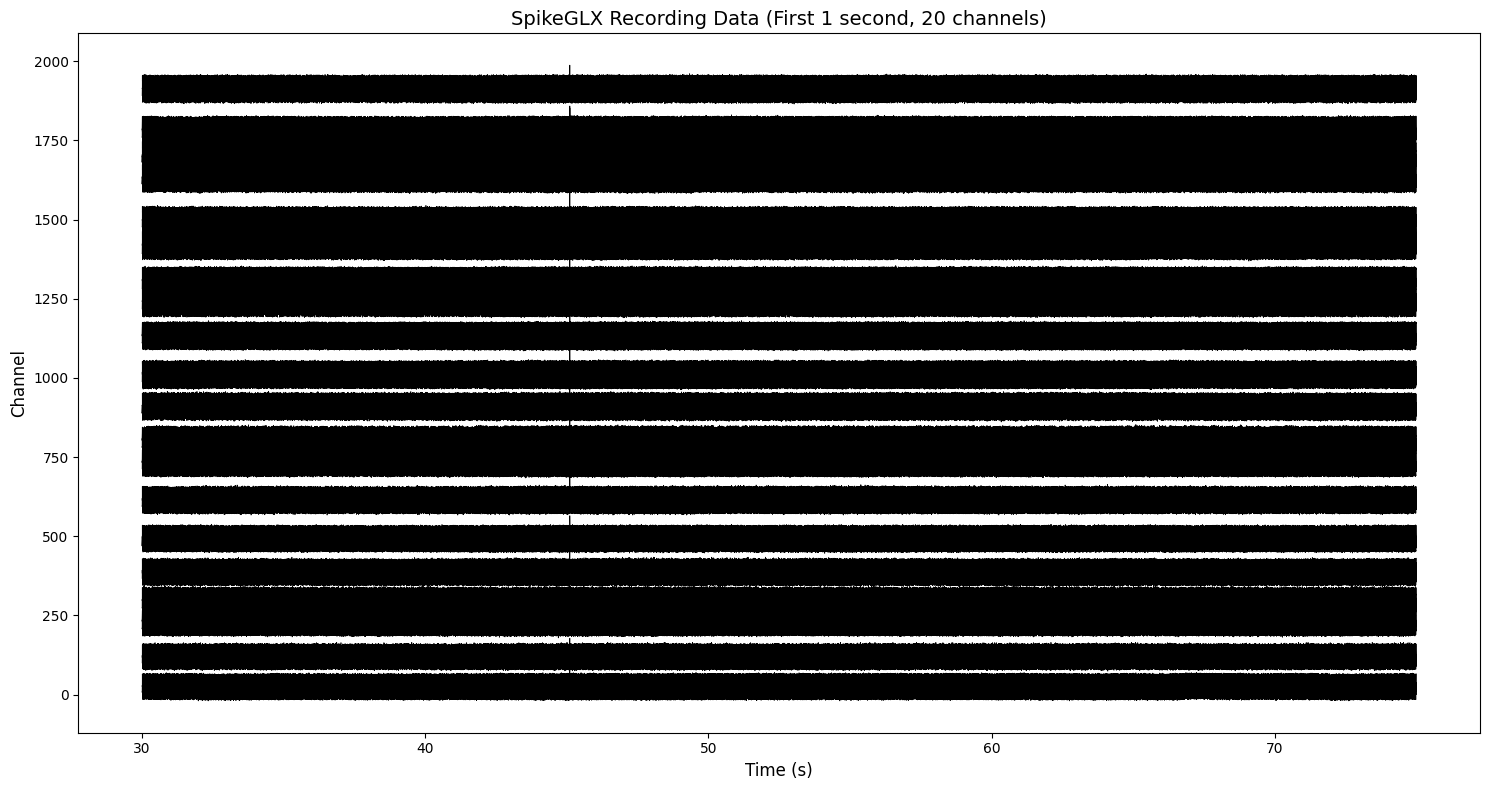

In [82]:
# データのトレースを可視化（最初の1秒間、最初の20チャンネル）
import matplotlib.pyplot as plt
import numpy as np
# データを取得（最初の1秒間）
traces = ap_rec.get_traces(
    start_frame=int(ap_rec.get_sampling_frequency() * start_time),
    end_frame=int(ap_rec.get_sampling_frequency() * end_time),  # 1秒分
    channel_ids=ap_rec.get_channel_ids()[:20]  # 最初の20チャンネル
)

# トレースを可視化
fig, ax = plt.subplots(figsize=(15, 8))
time = np.arange(traces.shape[0]) / ap_rec.get_sampling_frequency() + start_time

for i in range(traces.shape[1]):
    ax.plot(time, traces[:, i] + i * 100, linewidth=0.5, color='black')

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Channel', fontsize=12)
ax.set_title('SpikeGLX Recording Data (First 1 second, 20 channels)', fontsize=14)
plt.tight_layout()
plt.show()


## SYNCチャンネルも含めて処理する場合

SYNCチャンネルも含めて処理したい場合は、以下の方法を使用します：


In [83]:
# 元のrecording（全385チャンネル）を再読み込み
import spikeinterface as si  # import core only
recording_full = si.read_binary(
    file_paths=f_ap_bin,
    sampling_frequency=sampling_frequency,
    num_channels=num_channels,
    dtype='int16',
    time_axis=0,  # time x channels
    is_filtered=False,
)

# ゲイン情報を設定（全チャンネル）
gains_full = np.full(num_channels, gain_to_uv, dtype='float32')
recording_full.set_channel_gains(gains_full)

offsets_full = np.zeros(num_channels, dtype='float32')
recording_full.set_channel_offsets(offsets_full)

print(f"全チャンネル（AP + SYNC）のrecording:")
print(recording_full)


全チャンネル（AP + SYNC）のrecording:
BinaryRecordingExtractor: 385 channels - 30.0kHz - 1 segments - 2,279,612 samples 
                          75.99s (1.27 minutes) - int16 dtype - 1.63 GiB
  file_paths: ['F:\\TestRun20251020_09_g0\\TestRun20251020_09_g0_imec0\\TestRun20251020_09_g0_t0.imec0.ap.bin']


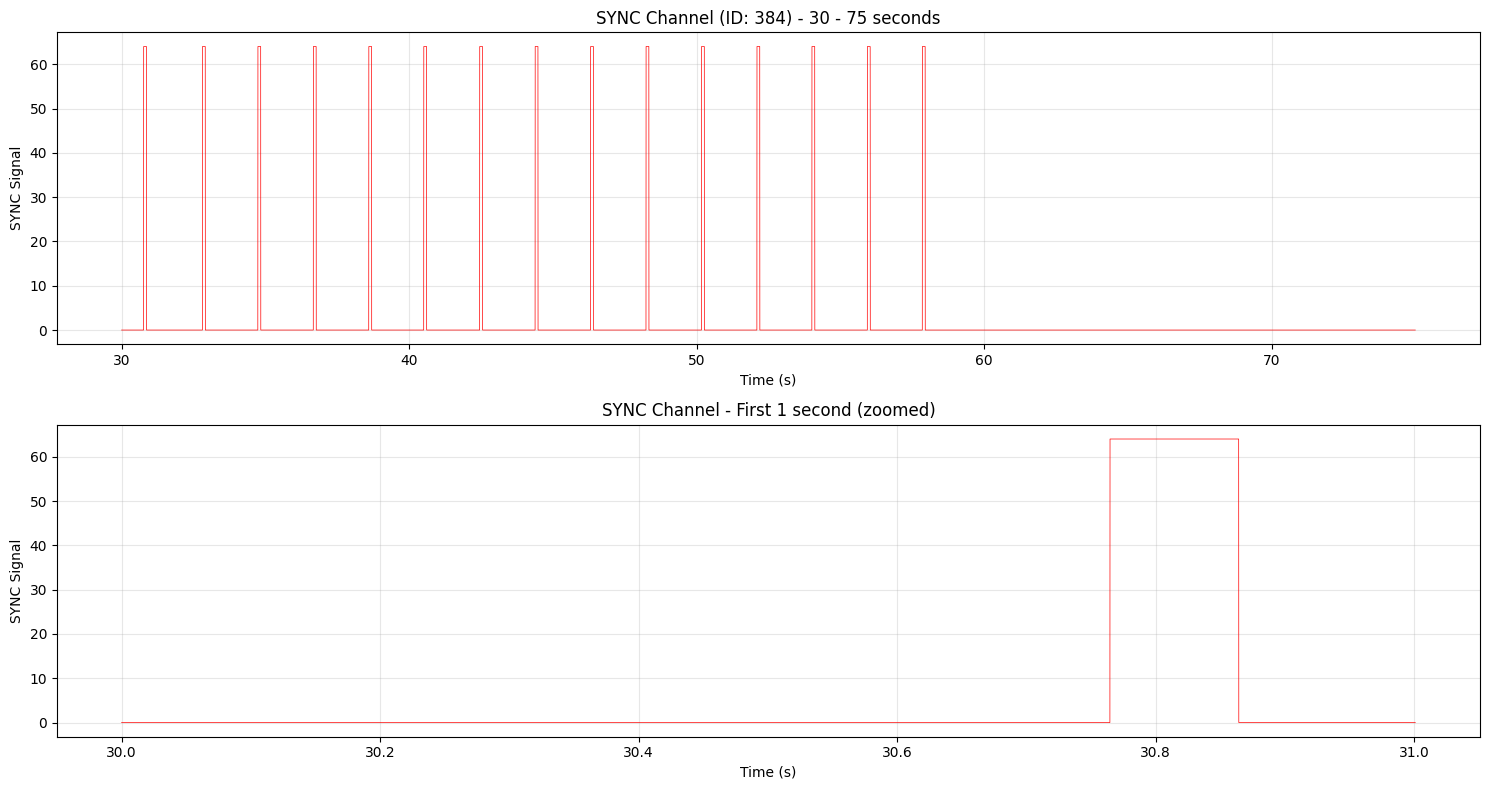

SYNCチャンネルの統計:
  最小値: 0
  最大値: 64
  平均値: 2.12
  標準偏差: 11.47


In [94]:
# SYNCチャンネルを可視化
sync_channel_id = recording_full.get_channel_ids()[-1]  # 最後のチャンネルがSYNC

# SYNCチャンネルのデータを取得
sync_traces = recording_full.get_traces(
    start_frame=int(recording_full.get_sampling_frequency() * start_time),
    end_frame=int(recording_full.get_sampling_frequency() * end_time),  
    channel_ids=[sync_channel_id]
)
# SYNCチャンネルを可視化
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# 全体の5秒間
time = np.arange(sync_traces.shape[0]) / recording_full.get_sampling_frequency() + start_time
ax1.plot(time, sync_traces[:, 0], linewidth=0.5, color='red')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('SYNC Signal')
ax1.set_title(f'SYNC Channel (ID: {sync_channel_id}) - {start_time} - {end_time} seconds')
ax1.grid(True, alpha=0.3)

# 最初の1秒間を拡大
zoom_end = int(recording_full.get_sampling_frequency()) + start_time
ax2.plot(time[:zoom_end], sync_traces[:zoom_end, 0], linewidth=0.5, color='red')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('SYNC Signal')
ax2.set_title('SYNC Channel - First 1 second (zoomed)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"SYNCチャンネルの統計:")
print(f"  最小値: {sync_traces.min()}")
print(f"  最大値: {sync_traces.max()}")
print(f"  平均値: {sync_traces.mean():.2f}")
print(f"  標準偏差: {sync_traces.std():.2f}")


C:\Users\tanaka-users\AppData\Local\Temp\ipykernel_21708\2359276931.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


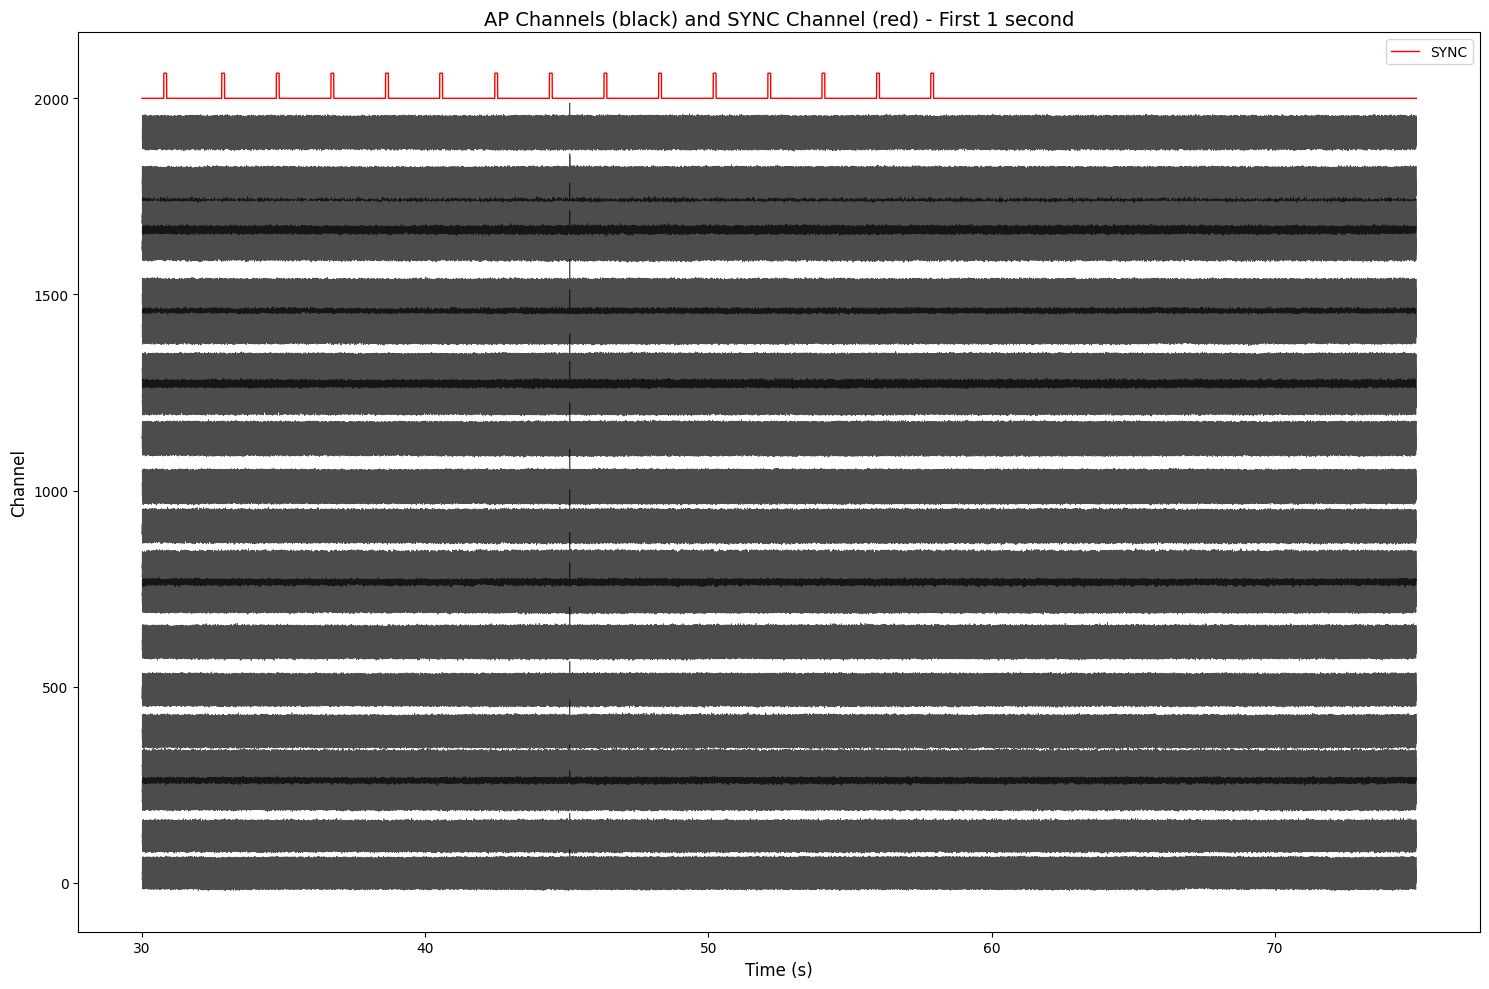

In [85]:
# APチャンネルとSYNCチャンネルを同時に可視化
# 最初の20 APチャンネル + SYNCチャンネル
ap_channels = recording_full.get_channel_ids()[:20]  # 最初の20 APチャンネル
all_channels = list(ap_channels) + [sync_channel_id]  # AP + SYNC

# データを取得（最初の1秒間）
traces_all = recording_full.get_traces(
    start_frame=int(recording_full.get_sampling_frequency() * start_time),
    end_frame=int(recording_full.get_sampling_frequency() * end_time),  # 1秒分
    channel_ids=all_channels
)

# 可視化
fig, ax = plt.subplots(figsize=(15, 10))
time = np.arange(traces_all.shape[0]) / recording_full.get_sampling_frequency() + start_time

# APチャンネルをプロット
for i in range(len(ap_channels)):
    ax.plot(time, traces_all[:, i] + i * 100, linewidth=0.5, color='black', alpha=0.7)

# SYNCチャンネルを赤色でプロット（最後のチャンネル）
sync_idx = len(ap_channels)
ax.plot(time, traces_all[:, sync_idx] + sync_idx * 100, linewidth=1, color='red', label='SYNC')

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Channel', fontsize=12)
ax.set_title('AP Channels (black) and SYNC Channel (red) - First 1 second', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()


In [86]:
# SYNCチャンネルにプローブ情報を設定する場合（位置情報なし）
# SYNCチャンネル用にダミーの位置を追加してプローブ情報を設定

if geom_str:
    # 元の位置情報にSYNCチャンネル用の位置を追加
    positions_with_sync = np.vstack([positions, [[0, 0]]])  # SYNCチャンネル用に(0,0)を追加
    
    # Probeinterfaceを使用してプローブ情報を設定（全チャンネル）
    from probeinterface import Probe, ProbeGroup
    
    probe_full = Probe(ndim=2, si_units='um')
    probe_full.set_contacts(positions=positions_with_sync, shapes='square', shape_params={'width': 12})
    probe_full.set_device_channel_indices(np.arange(num_channels))
    probe_full.create_auto_shape()
    
    # recordingにプローブ情報を設定
    recording_with_sync = recording_full.set_probe(probe_full, in_place=False)
    
    print(f"Set probe information for all channels (AP + SYNC)")
    print(f"Position information: {positions_with_sync.shape}")
    print(recording_with_sync)
    
    # SYNCチャンネルの位置を確認
    sync_position = recording_with_sync.get_probe().contact_positions[-1]
    print(f"SYNC channel position: ({sync_position[0]:.1f}, {sync_position[1]:.1f}) μm")
else:
    print("Warning: Channel position information not found")


Set probe information for all channels (AP + SYNC)
Position information: (385, 2)
BinaryRecordingExtractor: 385 channels - 30.0kHz - 1 segments - 2,279,612 samples 
                          75.99s (1.27 minutes) - int16 dtype - 1.63 GiB
  file_paths: ['F:\\TestRun20251020_09_g0\\TestRun20251020_09_g0_imec0\\TestRun20251020_09_g0_t0.imec0.ap.bin']
SYNC channel position: (0.0, 0.0) μm


# obxファイルのロード

In [87]:
import re
from pathlib import Path

def read_spikeglx_meta(meta_file):
    """SpikeGLXのメタファイルを読み込む"""
    meta_dict = {}
    with open(meta_file, 'r') as f:
        for line in f:
            line = line.strip()
            if '=' in line:
                key, value = line.split('=', 1)
                meta_dict[key] = value
    return meta_dict

# メタファイルの読み込み
obx_meta = read_spikeglx_meta(f_obx_meta)

# 重要な情報を取得
sampling_frequency = float(obx_meta['obSampRate'])
num_channels = int(obx_meta['nSavedChans'])
num_frames = int(obx_meta.get('fileSizeBytes', 0)) // (num_channels * 2)  # 2 bytes per sample (int16)

print(f"サンプリング周波数: {sampling_frequency} Hz")
print(f"チャンネル数: {num_channels}")
print(f"フレーム数: {num_frames}")
print(f"記録時間: {num_frames / sampling_frequency:.2f} 秒")

サンプリング周波数: 30303.0 Hz
チャンネル数: 14
フレーム数: 2302652
記録時間: 75.99 秒


In [88]:
# BinaryRecordingExtractorを使用してデータを読み込む
obx_rec = si.read_binary(
    file_paths=f_obx_bin,
    sampling_frequency=sampling_frequency,
    num_channels=num_channels,
    dtype='int16',
    time_axis=0,  # time x channels
    is_filtered=False,
)

print(obx_rec)

BinaryRecordingExtractor: 14 channels - 30.3kHz - 1 segments - 2,302,652 samples 
                          75.99s (1.27 minutes) - int16 dtype - 61.49 MiB
  file_paths: ['F:\\TestRun20251020_09_g0\\TestRun20251020_09_g0_t0.obx0.obx.bin']


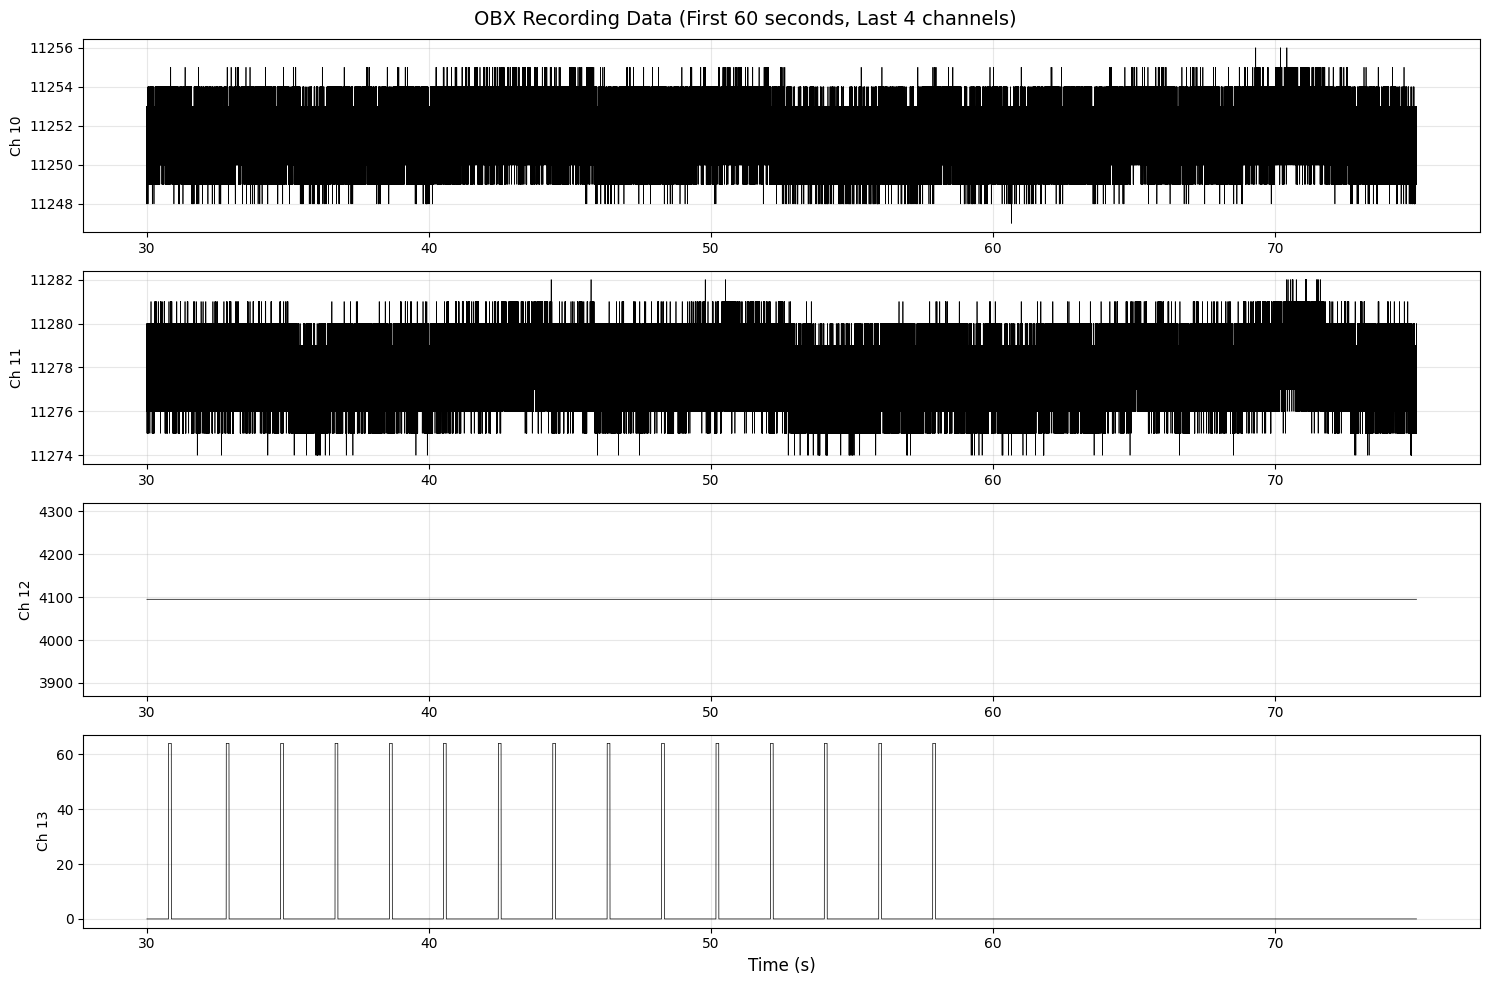

In [89]:
# データのトレースを可視化（最初の60秒間、最後の4チャンネル）
import matplotlib.pyplot as plt

# データを取得（最初の60秒間）
channel_ids = obx_rec.get_channel_ids()[-4:]  # 最後の4チャンネル
traces = obx_rec.get_traces(
    start_frame=int(obx_rec.get_sampling_frequency() * start_time),
    end_frame=int(obx_rec.get_sampling_frequency() * end_time),  # 60秒分
    channel_ids=channel_ids
)

# トレースを可視化
fig, ax = plt.subplots(nrows=len(channel_ids), ncols=1, figsize=(15, 10))
time = np.arange(traces.shape[0]) / obx_rec.get_sampling_frequency() + start_time

for i in range(traces.shape[1]):
    ax[i].plot(time, traces[:, i], linewidth=0.5, color='black')
    ax[i].set_ylabel(f'Ch {channel_ids[i]}', fontsize=10)
    ax[i].grid(True, alpha=0.3)

# 最後のサブプロットにx軸ラベルを設定
ax[-1].set_xlabel('Time (s)', fontsize=12)

# 全体のタイトルを設定
fig.suptitle('OBX Recording Data (First 60 seconds, Last 4 channels)', fontsize=14)

plt.tight_layout()
plt.show()

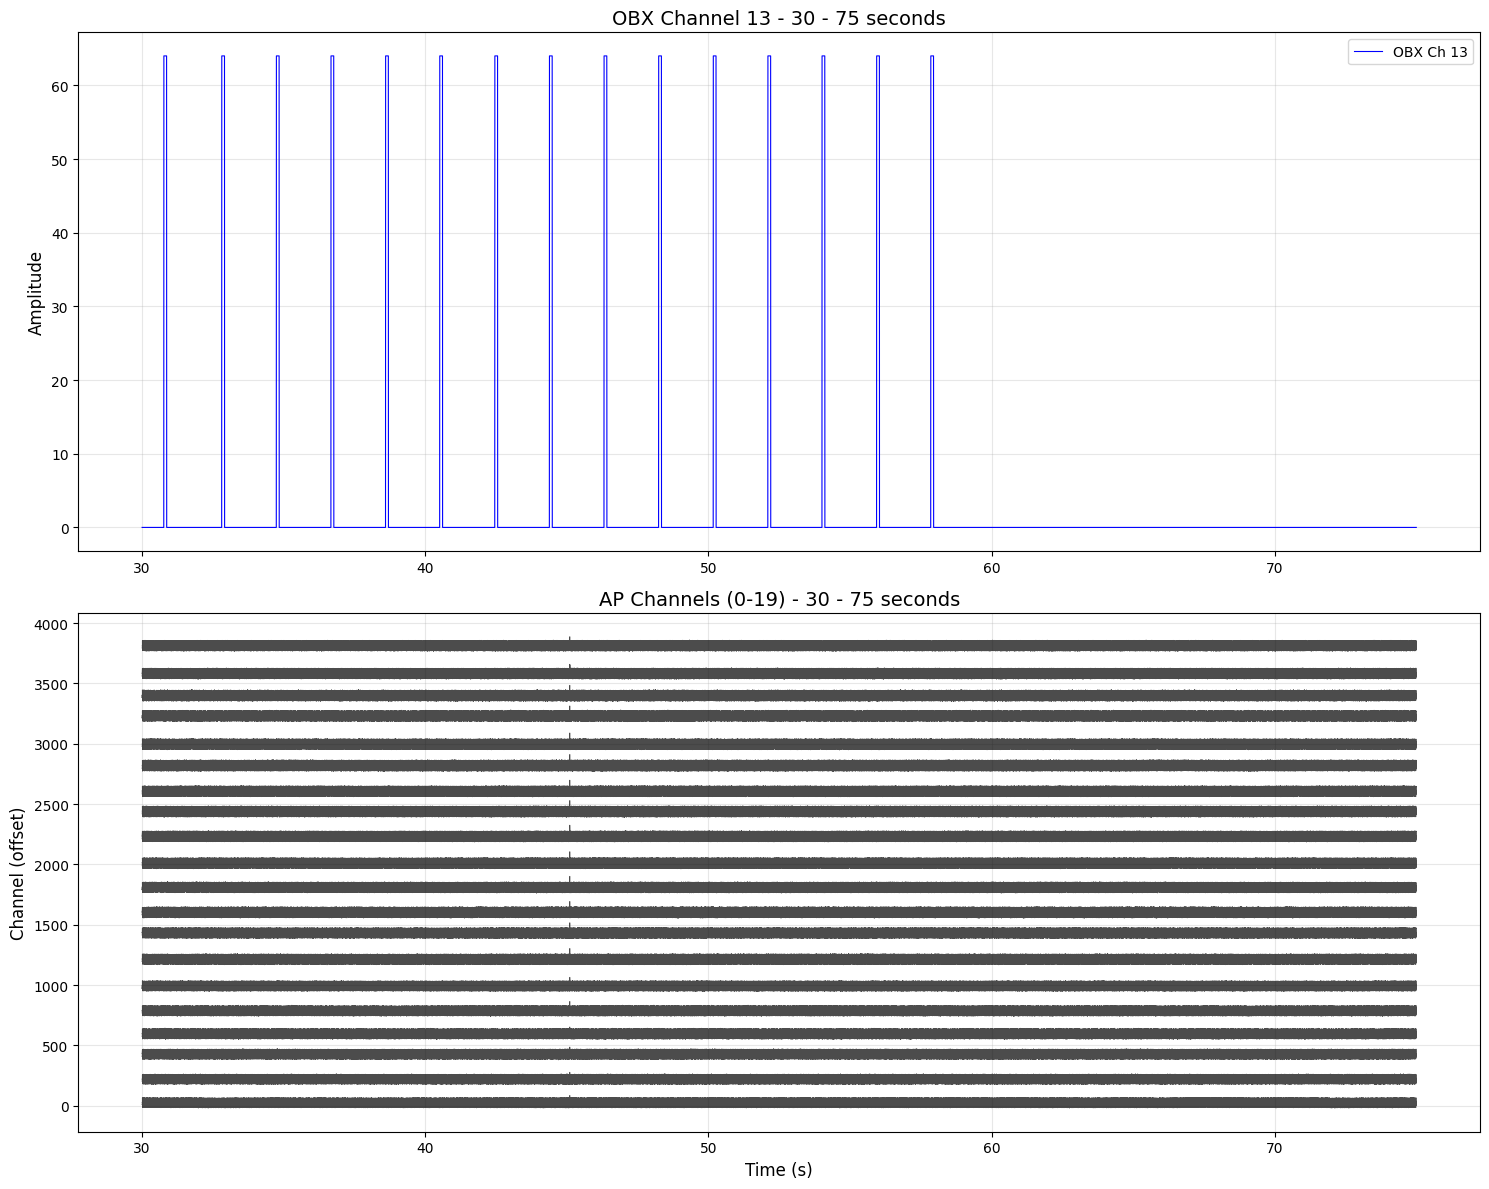

OBX Channel 13 統計:
  最小値: 0
  最大値: 64
  平均値: 2.13
  標準偏差: 11.47

AP Channels 統計:
  最小値: -66
  最大値: 130
  平均値: 11.86
  標準偏差: 25.32


In [90]:
# OBXの13チャンネルとAPチャンネルを並べてプロット

import matplotlib.pyplot as plt
import numpy as np

# OBXの13チャンネル（最後のチャンネル）のデータを取得
obx_channel_13 = obx_rec.get_channel_ids()[-1]  # 最後のチャンネル（13番目）
obx_traces = obx_rec.get_traces(
    start_frame=int(obx_rec.get_sampling_frequency() * start_time),
    end_frame=int(obx_rec.get_sampling_frequency() * end_time),
    channel_ids=[obx_channel_13]
)

# APチャンネル（最初の20チャンネル）のデータを取得
ap_channels = ap_rec.get_channel_ids()[:20]  # 最初の20 APチャンネル
ap_traces = ap_rec.get_traces(
    start_frame=int(ap_rec.get_sampling_frequency() * start_time),
    end_frame=int(ap_rec.get_sampling_frequency() * end_time),
    channel_ids=ap_channels
)

# 時間軸を作成
obx_time = np.arange(obx_traces.shape[0]) / obx_rec.get_sampling_frequency() + start_time
ap_time = np.arange(ap_traces.shape[0]) / ap_rec.get_sampling_frequency() + start_time

# プロットを作成
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# OBX 13チャンネルをプロット
ax1.plot(obx_time, obx_traces[:, 0], linewidth=0.8, color='blue', label=f'OBX Ch {obx_channel_13}')
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_title(f'OBX Channel {obx_channel_13} - {start_time} - {end_time} seconds', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# APチャンネルをプロット（オフセット付き）
for i in range(ap_traces.shape[1]):
    ax2.plot(ap_time, ap_traces[:, i] + i * 200, linewidth=0.5, color='black', alpha=0.7)

ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Channel (offset)', fontsize=12)
ax2.set_title(f'AP Channels (0-{len(ap_channels)-1}) - {start_time} - {end_time} seconds', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 統計情報を表示
print(f"OBX Channel {obx_channel_13} 統計:")
print(f"  最小値: {obx_traces.min()}")
print(f"  最大値: {obx_traces.max()}")
print(f"  平均値: {obx_traces.mean():.2f}")
print(f"  標準偏差: {obx_traces.std():.2f}")

print(f"\nAP Channels 統計:")
print(f"  最小値: {ap_traces.min()}")
print(f"  最大値: {ap_traces.max()}")
print(f"  平均値: {ap_traces.mean():.2f}")
print(f"  標準偏差: {ap_traces.std():.2f}")


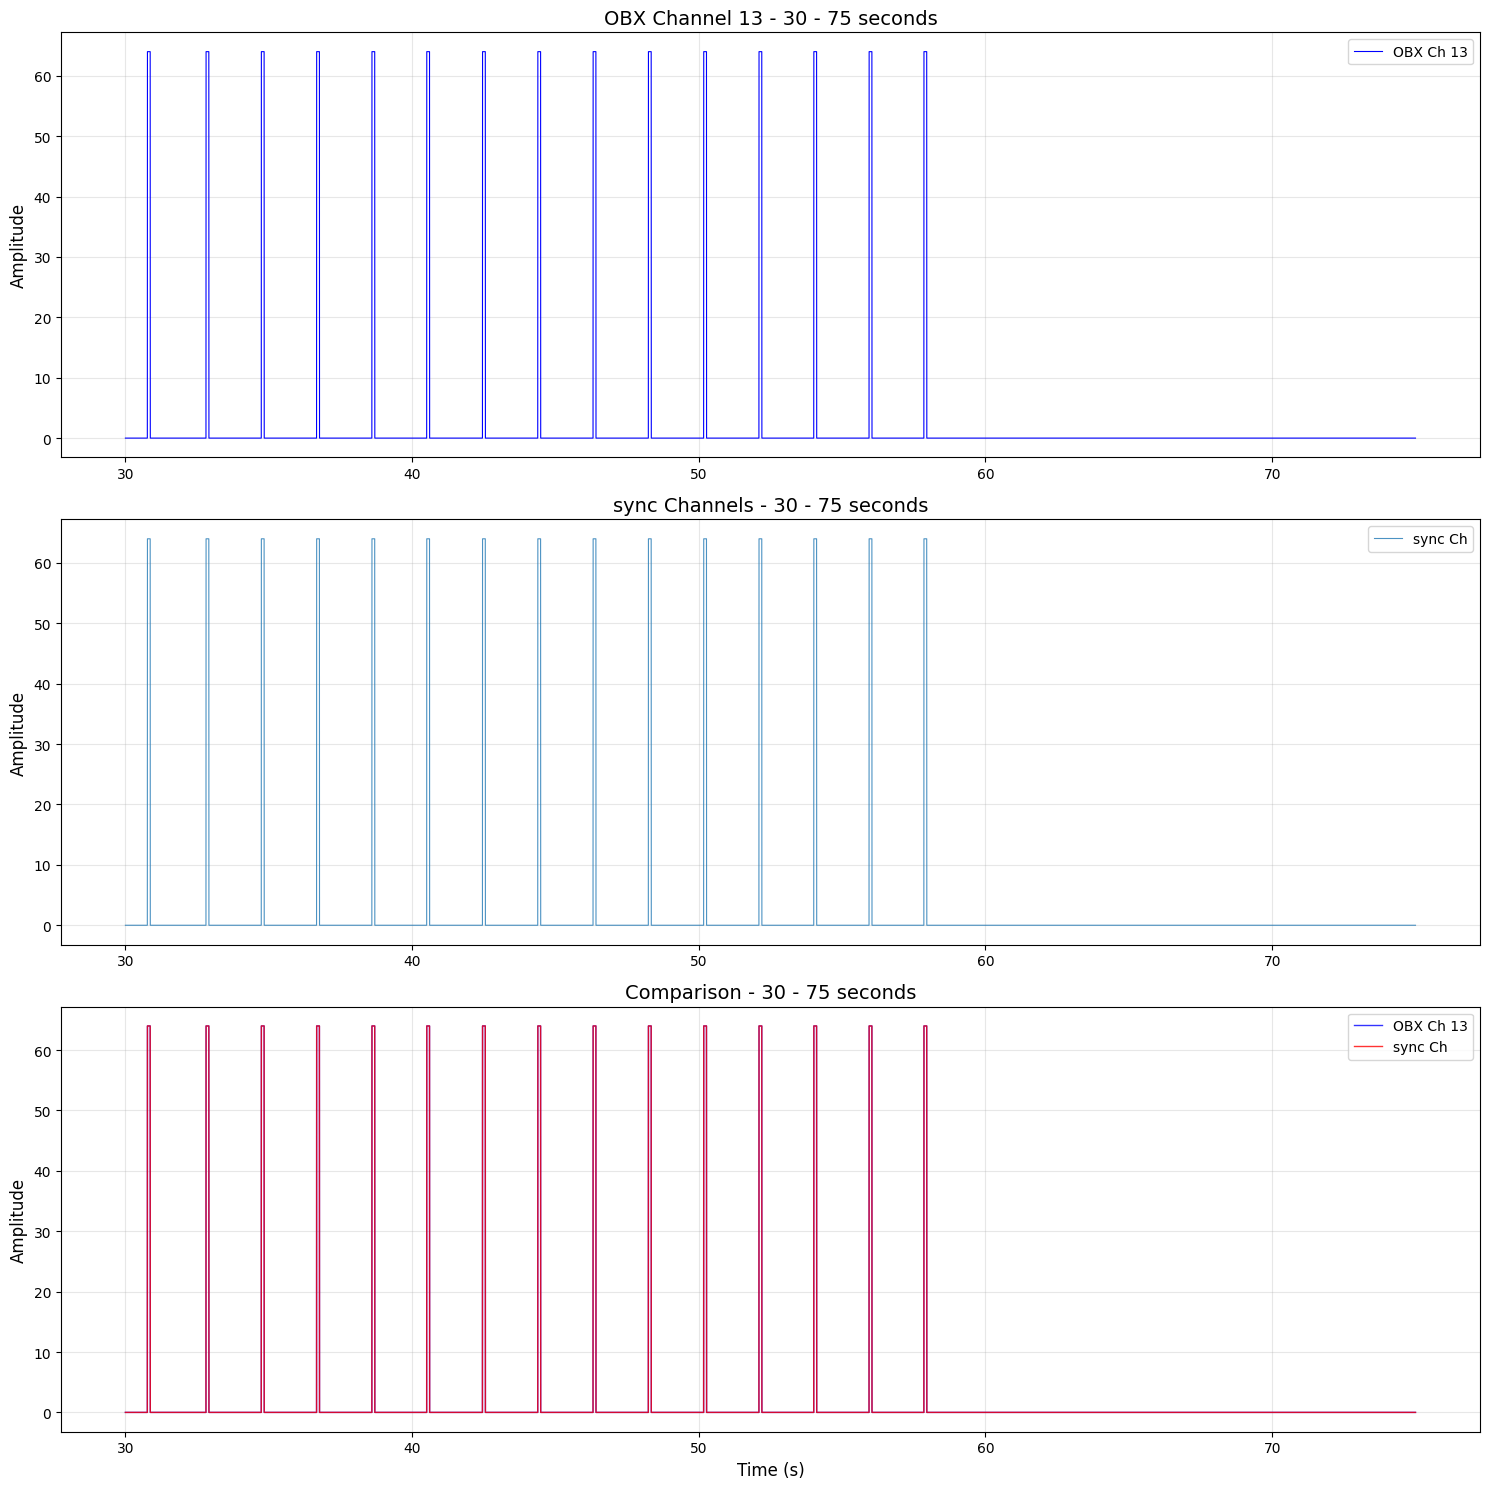

In [91]:
# OBXの13チャンネルとAPチャンネルを同じ時間軸で比較プロット

import matplotlib.pyplot as plt
import numpy as np

# OBXの13チャンネル（最後のチャンネル）のデータを取得
obx_channel_13 = obx_rec.get_channel_ids()[-1]
obx_traces = obx_rec.get_traces(
    start_frame=int(obx_rec.get_sampling_frequency() * start_time),
    end_frame=int(obx_rec.get_sampling_frequency() * end_time),
    channel_ids=[obx_channel_13]
)

# APチャンネル（最初の5チャンネル）のデータを取得
sync_channel = ap_rec.get_channel_ids()[-1]  # 最初の5 APチャンネル
sync_traces = ap_rec.get_traces(
    start_frame=int(ap_rec.get_sampling_frequency() * start_time),
    end_frame=int(ap_rec.get_sampling_frequency() * end_time),
    channel_ids=[sync_channel]
)

# 時間軸を作成（同じ時間範囲で正規化）
obx_time = np.arange(obx_traces.shape[0]) / obx_rec.get_sampling_frequency() + start_time
ap_time = np.arange(ap_traces.shape[0]) / ap_rec.get_sampling_frequency() + start_time

# プロットを作成（3つのサブプロット）
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# 1. OBX 13チャンネル
ax1.plot(obx_time, obx_traces[:, 0], linewidth=0.8, color='blue', label=f'OBX Ch {obx_channel_13}')
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_title(f'OBX Channel {obx_channel_13} - {start_time} - {end_time} seconds', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. APチャンネル（個別表示）

ax2.plot(ap_time, sync_traces[:, 0], linewidth=0.8, label=f'sync Ch', alpha=0.8)

ax2.set_ylabel('Amplitude', fontsize=12)
ax2.set_title(f'sync Channels - {start_time} - {end_time} seconds', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. オーバーレイ表示（正規化して比較）
# データを正規化（0-1の範囲に）
ax3.plot(obx_time, obx_traces, linewidth=1, color='blue', label=f'OBX Ch {obx_channel_13}', alpha=0.8)
ax3.plot(ap_time, sync_traces, linewidth=1, color='red', label=f'sync Ch', alpha=0.8)

ax3.set_xlabel('Time (s)', fontsize=12)
ax3.set_ylabel('Amplitude', fontsize=12)
ax3.set_title(f'Comparison - {start_time} - {end_time} seconds', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

C:\Users\tanaka-users\AppData\Local\Temp\ipykernel_21708\194987776.py:60: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


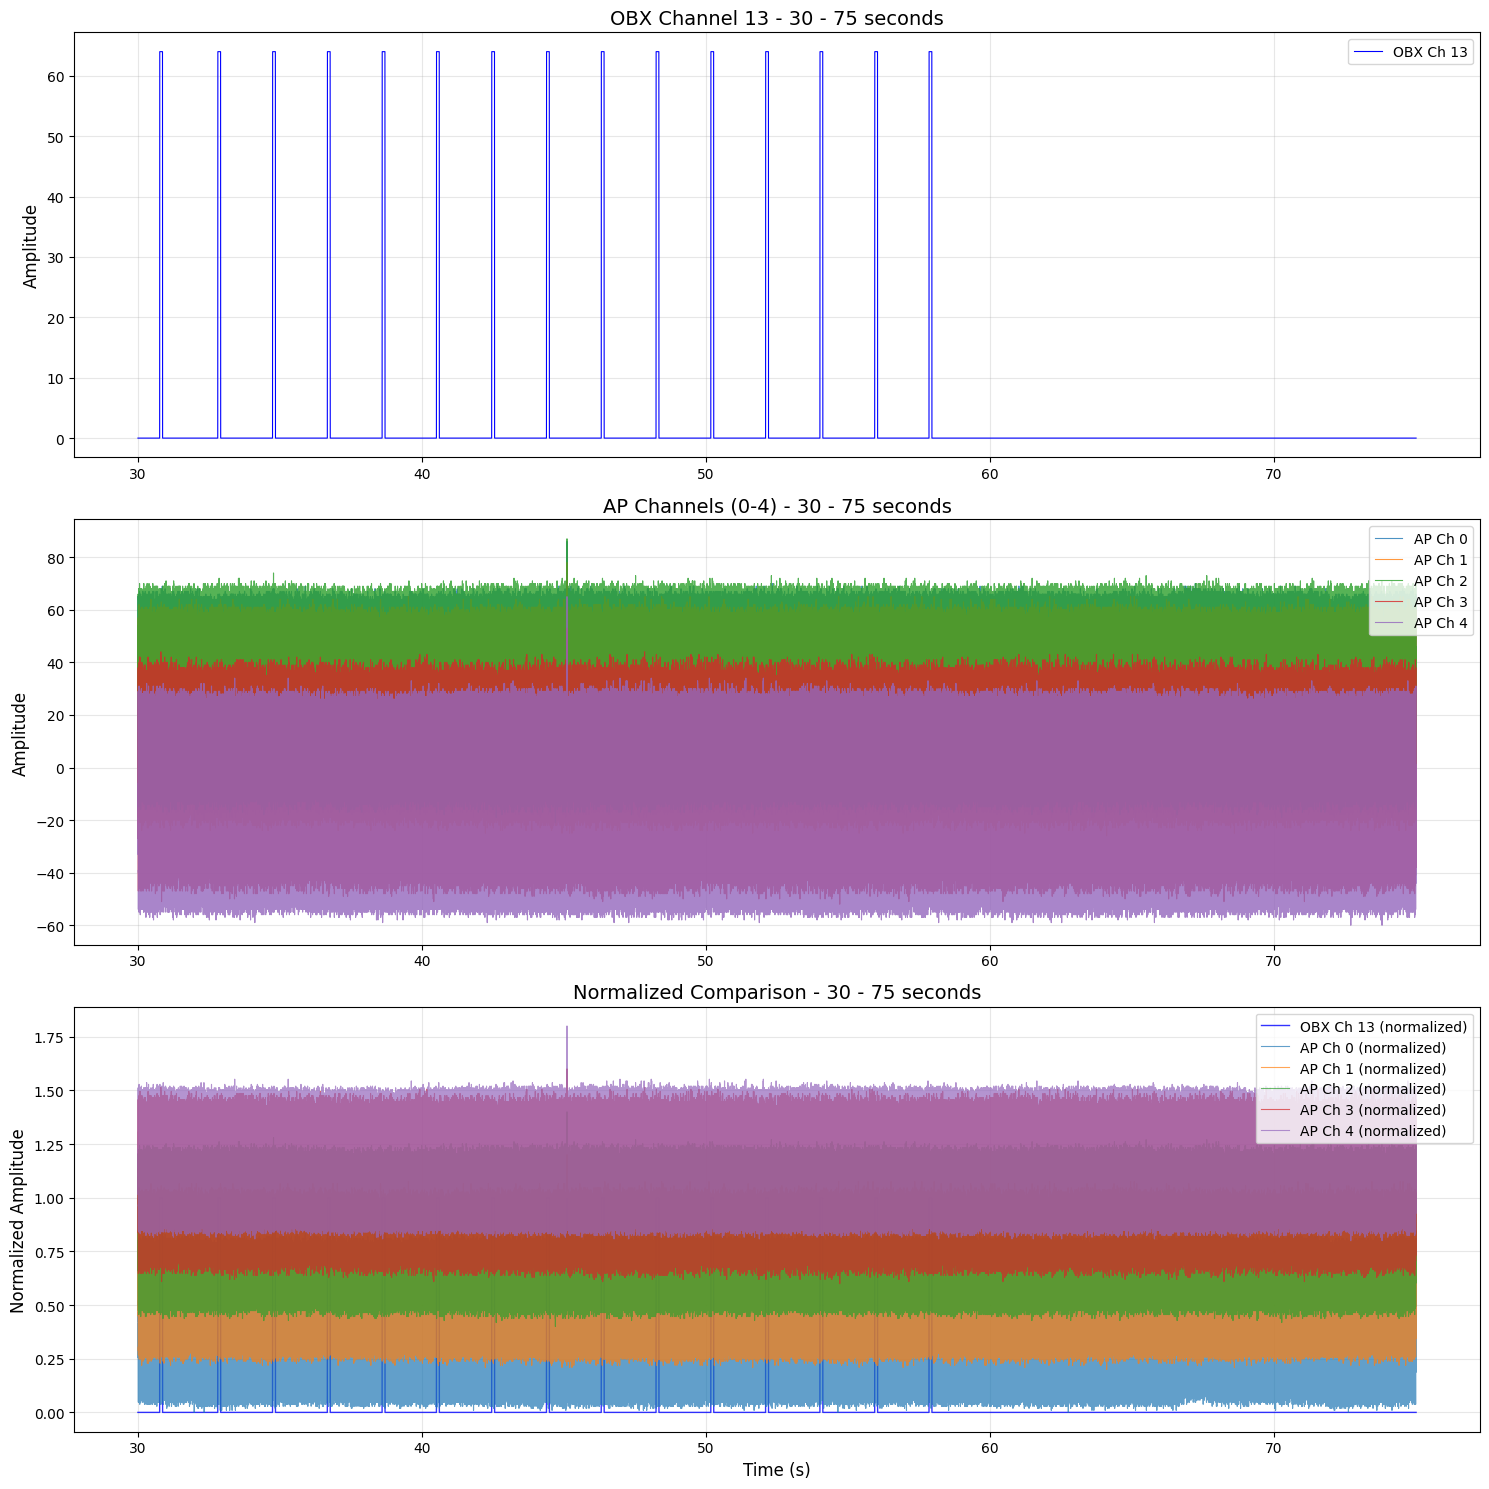

=== OBX Channel 13 詳細統計 ===
  サンプリング周波数: 30303.0 Hz
  データポイント数: 1363635
  最小値: 0
  最大値: 64
  平均値: 2.13
  標準偏差: 11.47
  中央値: 0.00

=== AP Channels 詳細統計 ===
  サンプリング周波数: 30000.0 Hz
  データポイント数: 1350000
  Ch 0: 最小=-20, 最大=86, 平均=25.09
  Ch 1: 最小=-26, 最大=78, 平均=19.51
  Ch 2: 最小=-21, 最大=87, 平均=27.49
  Ch 3: 最小=-52, 最大=53, 平均=-3.81
  Ch 4: 最小=-60, 最大=65, 平均=-13.41


In [92]:
# OBXの13チャンネルとAPチャンネルを同じ時間軸で比較プロット

import matplotlib.pyplot as plt
import numpy as np

# OBXの13チャンネル（最後のチャンネル）のデータを取得
obx_channel_13 = obx_rec.get_channel_ids()[-1]
obx_traces = obx_rec.get_traces(
    start_frame=int(obx_rec.get_sampling_frequency() * start_time),
    end_frame=int(obx_rec.get_sampling_frequency() * end_time),
    channel_ids=[obx_channel_13]
)

# APチャンネル（最初の5チャンネル）のデータを取得
ap_channels = ap_rec.get_channel_ids()[:5]  # 最初の5 APチャンネル
ap_traces = ap_rec.get_traces(
    start_frame=int(ap_rec.get_sampling_frequency() * start_time),
    end_frame=int(ap_rec.get_sampling_frequency() * end_time),
    channel_ids=ap_channels
)

# 時間軸を作成（同じ時間範囲で正規化）
obx_time = np.arange(obx_traces.shape[0]) / obx_rec.get_sampling_frequency() + start_time
ap_time = np.arange(ap_traces.shape[0]) / ap_rec.get_sampling_frequency() + start_time

# プロットを作成（3つのサブプロット）
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# 1. OBX 13チャンネル
ax1.plot(obx_time, obx_traces[:, 0], linewidth=0.8, color='blue', label=f'OBX Ch {obx_channel_13}')
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_title(f'OBX Channel {obx_channel_13} - {start_time} - {end_time} seconds', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. APチャンネル（個別表示）
for i in range(ap_traces.shape[1]):
    ax2.plot(ap_time, ap_traces[:, i], linewidth=0.8, label=f'AP Ch {ap_channels[i]}', alpha=0.8)

ax2.set_ylabel('Amplitude', fontsize=12)
ax2.set_title(f'AP Channels (0-{len(ap_channels)-1}) - {start_time} - {end_time} seconds', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. オーバーレイ表示（正規化して比較）
# データを正規化（0-1の範囲に）
obx_normalized = (obx_traces[:, 0] - obx_traces[:, 0].min()) / (obx_traces[:, 0].max() - obx_traces[:, 0].min())
ax3.plot(obx_time, obx_normalized, linewidth=1, color='blue', label=f'OBX Ch {obx_channel_13} (normalized)', alpha=0.8)

for i in range(ap_traces.shape[1]):
    ap_normalized = (ap_traces[:, i] - ap_traces[:, i].min()) / (ap_traces[:, i].max() - ap_traces[:, i].min())
    ax3.plot(ap_time, ap_normalized + i * 0.2, linewidth=0.8, label=f'AP Ch {ap_channels[i]} (normalized)', alpha=0.7)

ax3.set_xlabel('Time (s)', fontsize=12)
ax3.set_ylabel('Normalized Amplitude', fontsize=12)
ax3.set_title(f'Normalized Comparison - {start_time} - {end_time} seconds', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

# 詳細な統計情報を表示
print(f"=== OBX Channel {obx_channel_13} 詳細統計 ===")
print(f"  サンプリング周波数: {obx_rec.get_sampling_frequency()} Hz")
print(f"  データポイント数: {obx_traces.shape[0]}")
print(f"  最小値: {obx_traces.min()}")
print(f"  最大値: {obx_traces.max()}")
print(f"  平均値: {obx_traces.mean():.2f}")
print(f"  標準偏差: {obx_traces.std():.2f}")
print(f"  中央値: {np.median(obx_traces):.2f}")

print(f"\n=== AP Channels 詳細統計 ===")
print(f"  サンプリング周波数: {ap_rec.get_sampling_frequency()} Hz")
print(f"  データポイント数: {ap_traces.shape[0]}")
for i, ch_id in enumerate(ap_channels):
    print(f"  Ch {ch_id}: 最小={ap_traces[:, i].min()}, 最大={ap_traces[:, i].max()}, 平均={ap_traces[:, i].mean():.2f}")
